Eğitim verisi boyutu: (10178, 300)
Test verisi boyutu: (2545, 300)
[0]	train-logloss:0.64810	eval-logloss:0.65523
[1]	train-logloss:0.60876	eval-logloss:0.62141
[2]	train-logloss:0.57353	eval-logloss:0.58976
[3]	train-logloss:0.54232	eval-logloss:0.56405
[4]	train-logloss:0.51511	eval-logloss:0.54103
[5]	train-logloss:0.49122	eval-logloss:0.52062
[6]	train-logloss:0.46933	eval-logloss:0.50233
[7]	train-logloss:0.44912	eval-logloss:0.48574
[8]	train-logloss:0.43080	eval-logloss:0.47151
[9]	train-logloss:0.41295	eval-logloss:0.45732
[10]	train-logloss:0.39730	eval-logloss:0.44538
[11]	train-logloss:0.38203	eval-logloss:0.43224
[12]	train-logloss:0.36863	eval-logloss:0.42023
[13]	train-logloss:0.35637	eval-logloss:0.41081
[14]	train-logloss:0.34456	eval-logloss:0.40145
[15]	train-logloss:0.33318	eval-logloss:0.39316
[16]	train-logloss:0.32237	eval-logloss:0.38509
[17]	train-logloss:0.31246	eval-logloss:0.37871
[18]	train-logloss:0.30288	eval-logloss:0.37136
[19]	train-logloss:0.29399	eval

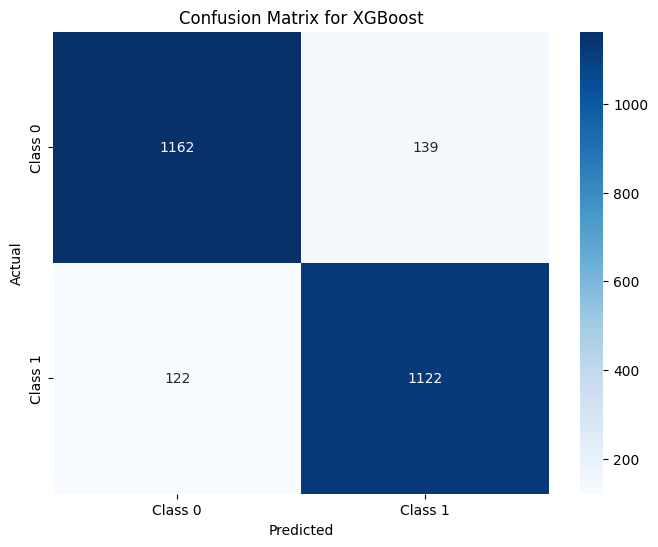

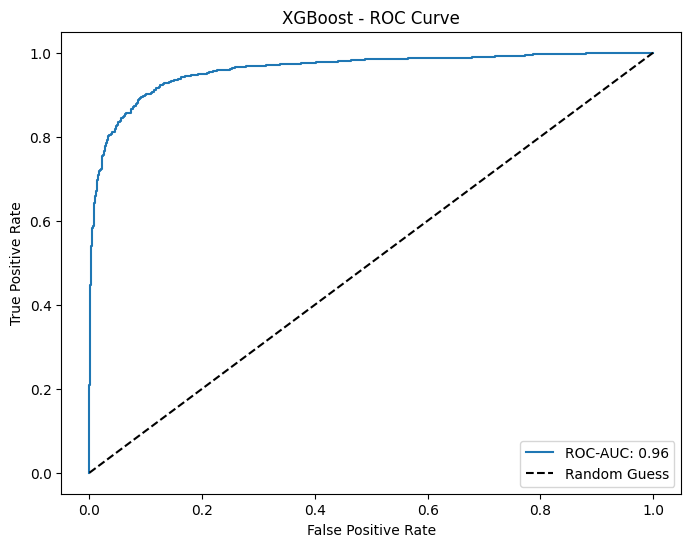

In [3]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

# PKL dosyasını yükleme
with open("fasttext_vectors.pkl", "rb") as file:
    X, y = pickle.load(file)

# NumPy dizilerine dönüştürme
X = np.array(X)
y = np.array(y)

# Eğitim ve test veri setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Eğitim verisi boyutu:", X_train.shape)
print("Test verisi boyutu:", X_test.shape)

# XGBoost modeli için DMatrix formatına dönüştürme
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost parametreleri
params = {
    'objective': 'binary:logistic',  # İkili sınıflandırma için
    'eval_metric': 'logloss',       # Değerlendirme metriği
    'eta': 0.1,                     # Öğrenme oranı
    'max_depth': 6,                 # Maksimum derinlik
    'seed': 42                      # Rastgelelik için sabit değer
}

# XGBoost modelini eğitme
num_round = 100  # Eğitim için tur sayısı
evals = [(dtrain, 'train'), (dtest, 'eval')]  # Eğitim ve değerlendirme veri setleri
bst = xgb.train(params, dtrain, num_round, evals=evals, early_stopping_rounds=10)

# Tahmin yapma
y_pred_prob = bst.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

# Modelin doğruluğunu hesaplama
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Model Accuracy: {accuracy:.2f}")

# Detaylı rapor (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"]))

# Karmaşıklık matrisi oluşturma ve görselleştirme
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for XGBoost")
plt.show()

# ROC-AUC Hesaplama ve Grafik (İkili sınıflandırma kontrolü)
if len(set(y_test)) == 2:  # Yalnızca ikili sınıflandırma için geçerli
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC-AUC: {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("XGBoost - ROC Curve")
    plt.legend()
    plt.show()
